# Forecasting Exercises
This exercise walks through a SARIMA prediction and forecast similar to the one done on the Mauna Loa CO₂ dataset.<br>
This time we're using a seasonal time series of California Hospitality Industry Employees.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose # for ETS Plots
from pmdarima import auto_arima # for determining ARIMA orders
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../dataset/HospitalityEmployees.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


So <tt>df</tt> has 348 records and one column. The data represents the number of employees in thousands of persons as monthly averages from January, 1990 to December 2018.

### 1. Plot the source data
Create a line chart of the dataset. Optional: add a title and y-axis label.

<Axes: xlabel='Date'>

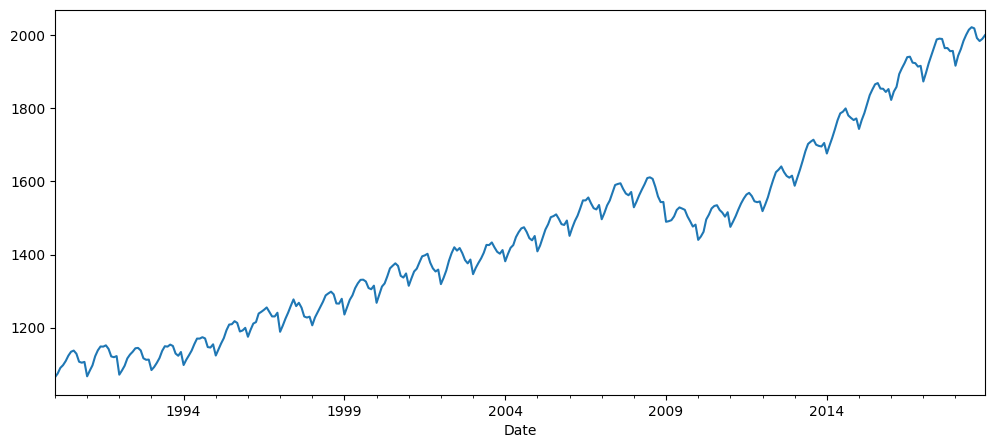

In [3]:
df['Employees'].plot(figsize=(12,5))

### 2. Run an ETS Decomposition
Use an 'additive' model.

In [4]:
result = seasonal_decompose(df['Employees'],model='add')

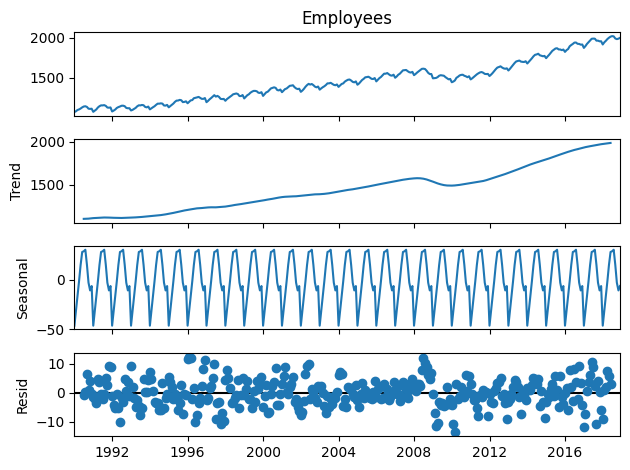

In [5]:
result.plot();

### 3. Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [6]:
auto_arima(df['Employees'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.252
Date:                              Thu, 02 Jan 2025   AIC                           2208.504
Time:                                      16:02:57   BIC                           2231.600
Sample:                                  01-01-1990   HQIC                          2217.700
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9244      0.045     20.595      0.000       0.836       1.012
ma.L1         -0.9440      0.070    -13.438      0.000      -1.082      -0.806
ma.L2          0.1287      0.060      2.144      0.032       0.011       0.246
ar.S.L12       0.9972      0.001    704.608      0.000       0.994       1.000
ma.S.L12      -0.7490      0.043    -17.315      0.000      -0.834      -0.664
sigma2        29.2984      1.717     17.063      0.000      25.933      32.664
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

You should see a recommended ARIMA Order of (0,1,0) combined with a seasonal order of (2,0,0,12).
### 4. Split the data into train/test sets
Set one year (12 records) for testing. There is more than one way to do this!

In [7]:
train = df.iloc[:len(df)-12]

In [8]:
test = df.iloc[len(df)-12:]

### 5. Fit a SARIMA(0,1,0)(2,0,0,12) model to the training set

In [9]:
model = SARIMAX(train['Employees'],order=(0,1,0),seasonal_order=(2,0,0,12))

In [10]:
results = model.fit()

In [11]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Employees   No. Observations:                  336
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1095.407
Date:                            Thu, 02 Jan 2025   AIC                           2196.814
Time:                                    16:02:58   BIC                           2208.256
Sample:                                01-01-1990   HQIC                          2201.375
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5204      0.040     13.051      0.000       0.442       0.599
ar.S.L24       0.4385      0.041     10.593      0.000       0.357       0.520
sigma2        37.1907      2.165     17.175      0.000      32.947      41.435
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                56.66
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.35
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6. Obtain predicted values

In [12]:
start = len(train)

In [13]:
end = len(train) + len(test) - 1

In [14]:
predictions = results.predict(start,end,typ='levels').rename('SARIMA test predictions')

### 7. Plot predictions against known values
Optional: add a title and y-axis label.

<Axes: xlabel='Date'>

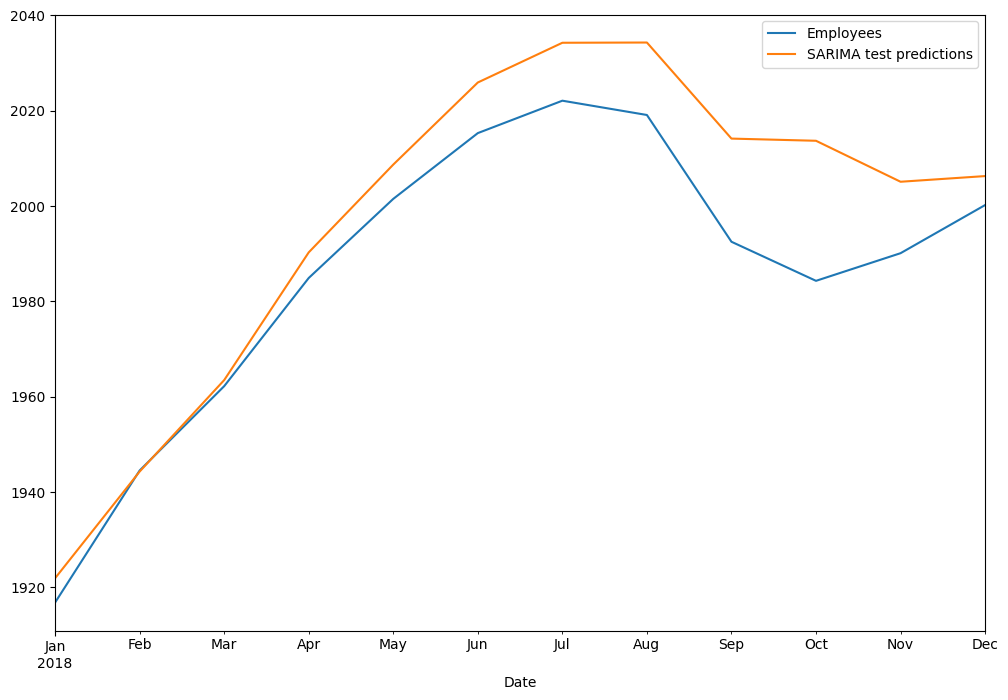

In [15]:
test['Employees'].plot(figsize=(12,8),legend=True)
predictions.plot(legend=True)

### 8. Evaluate the Model using MSE and RMSE
You can run both from the same cell if you want.

In [16]:
rmse(test['Employees'],predictions)

13.522228577656286

In [17]:
mean_squared_error(test['Employees'],predictions)

182.85066570638432

In [18]:
13.522228577656286 ** 2

182.85066570638432

### 9. Retrain the model on the full data and forecast one year into the future

In [19]:
model = SARIMAX(df['Employees'],order=(0,1,0),seasonal_order=(2,0,0,12))

In [20]:
results = model.fit()

In [21]:
fcast = results.predict(start=len(df),end=len(df)+11,typ='levels').rename('SARIMA forecast')

### 10. Plot the forecasted values alongside the original data
Optional: add a title and y-axis label.

<Axes: xlabel='Date'>

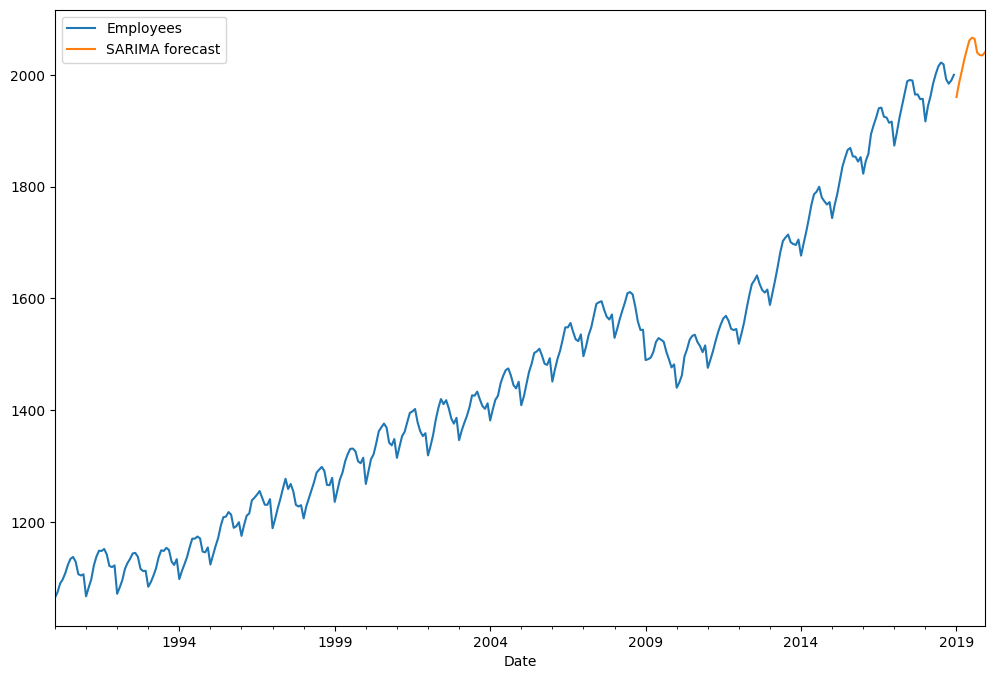

In [22]:
df['Employees'].plot(figsize=(12,8),legend=True)
fcast.plot(legend=True)